In [1]:
import os 
import math
import shutil
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm 
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras import Model 
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, MultiHeadAttention, \
                        AveragePooling2D, GlobalAveragePooling2D, ReLU, Dropout, LayerNormalization, Add
from tensorflow.keras import layers
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
BATCH_SIZE = 256 
PATCH_SIZE = (16, 16)
IMG_RESIZE_SHAOE = (224, 244)
PROJ_DIMS = 256
PATCH_SIZE = 4
IMG_WIDTH = 32 
IMG_HEIGHT = 32 
IMG_CHANNELS = 3
NUM_PATCH = 64
PATCH_DIMS = 64
NUM_CLS = 100
NUM_ENCODER = 8
MLP_DIMS_1 = 1024
MLP_DIMS_2 = 64
NUM_HEAD = 6

## VIT DataLoader

In [3]:
class DataLoader: 
    """
        Class, will be useful for creating the BYOL dataset or dataset for the DownStream task 
            like classification or segmentation.
        Methods:
            __normalize(scope: private)
            __preprocess_img(scope: private)
             __get_valdata(scope: private)
            get_vit_dataset(scope: public)
        
        Property:
            dname(dtype: str)        : dataset name(supports cifar10, cifar100).
            augmentor(type)          : byol augmentor instance/object.
            nval(type: int)          : Number of validation data needed, this will be created by splitting the testing
                                       data.
            resize_shape(dtype: int) : Resize shape, bcoz pretrained models, might have a different required shape.
            normalize(dtype: bool)   : bool value, whether to normalize the data or not. 
    """
    
    def __init__(self, dname="cifar10", augmentor=None, nval=5000,
                                             resize_shape=96, normalize=True): 
        assert dname in ["cifar10", 'cifar100'], "dname should be either cifar10 or cifar100"
        assert nval <= 10_000, "ValueError: nval value should be <= 10_000"
        
        __train_data, __test_data = self.__download_data(dname)
        self.__train_X, self.__train_y = __train_data
        self.__dtest_X, self.__dtest_y = __test_data 
        self.class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                                           'dog', 'frog', 'horse', 'sheep', 'truck']
        self.augmentor = augmentor
        self.__get_valdata(nval)
        self.resize_shape = resize_shape
        
        self.__normalize() if normalize else None
        self.min_obj_cov_value = 0.7
        self.color_jitter_value = 0.1
        
    def __len__(self): 
        return self.__train_X.shape[0] + self.__dtest_X.shape[0]
    
    def __repr__(self): 
        return f"Training Samples: {self.__train_X.shape[0]}, Testing Samples: {self.__dtest_X.shape[0]}"
    
    def __download_data(self, dname):
        """
            Downloads the data from the tensorflow website using the tensorflw.keras.load_data() method.
            Params:
                dname(type: Str): dataset name, it just supports two dataset cifar10 or cifar100
            Return(type(np.ndarray, np.ndarray))
                returns the training data and testing data
        """
        if dname == "cifar10": 
            train_data, test_data = tf.keras.datasets.cifar10.load_data()
        if dname == "cifar100": 
            train_data, test_data = tf.keras.datasets.cifar100.load_data()
            
        return train_data, test_data
    
    def __normalize(self): 
        """
            this method, will used to normalize the inputs.
        """
        self.__train_X = self.__train_X / 255.0
        self.__dtest_X = self.__dtest_X / 255.0
    
    def __preprocess_img(self, image, label): 
        """
            this method, will be used by the get_byol_dataset methos, which does a convertion of 
            numpy data to tensorflow data.
            Params:
                image(type: np.ndarray): image data.
            Returns(type; (np.ndarray, np.ndarray))
                returns the two different augmented views of same image.
        """
        try: 
            image = tf.image.convert_image_dtype(image, tf.float32)
            preprocessed_image = self.augmentor.augment(image)
            
            return preprocessed_image, label
        
        except Exception as err:
            return err
    
    def get_vit_dataset(self, batch_size, dataset_type="train"):
        """
            this method, will gives the byol dataset, which is nothing but a tf.data.Dataset object.
            Params:
                batch_size(dtype: int)    : Batch Size.
                dataset_type(dtype: str)  : which type of dataset needed, (train, test or val)
                
            return(type: tf.data.Dataset)
                returns the tf.data.Dataset for intended dataset_type, by preprocessing and converting 
                the np data.
        """
        try:
            if dataset_type == "train":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__train_X, self.__train_y))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "test":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__test_X, self.__test_y))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "val":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__val_X, self.__val_y))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
        
        except Exception as err:
            return err
    
    def __get_valdata(self, nval):
        """
            this method is used to create a validation data by randomly sampling from the testing data.
            Params:
                nval(dtype: Int); Number of validation data needed, rest of test_X.shape[0] - nval, will be 
                                  testing data size.
            returns(type; np.ndarray, np.ndarray):
                returns the testing and validation dataset.
        """
        try: 
            ind_arr = np.arange(10_000)
            val_inds = np.random.choice(ind_arr, nval)
            test_inds = [i for i in ind_arr if not i in val_inds]

            self.__test_X, self.__test_y = self.__dtest_X[test_inds], self.__dtest_y[test_inds]
            self.__val_X, self.__val_y = self.__dtest_X[val_inds], self.__dtest_y[val_inds]
            
        except Exception as err:
            raise err    

## VIT Augmentation Class

In [4]:
class VITAugmentor: 
    """
        This class is used for the data augmentation for the byol model.
        Methods: 
            __random_flip(scope: private)
            __random_zoom(scope: private)
            augment(scope: public)
    """
    def __init__(self): 
        pass 
    
    @tf.function
    def __random_flip(self, image):
        """
            this method does a random crop with height and width of the crop are sampled randomly. it does the 
            crop with the height and width, then it does a resizing again to the original shape. And also it does
            a flip of the image
            Params:
                image(type: tf.Tensor)   : image data of type tensor.
                resize_shape(type: int)  : Size of the image.
            Return(type: tf.Tensor)
                returns the crop and resized image.
        """
        try: 
            image = tf.image.random_flip_left_right(image) 
            return image
        
        except Exception as err:
            return err
    
    @tf.function
    def __random_zoom(self, image):
        """
            this method, will do the color disortion augmentation for the given image.
            Params:
                image(type: tf.Tensor)   : image data of type tensor.
            Return(type: tf.Tensor)
                returns the crop and resized image.
        """
        try: 
            image = tf.keras.preprocessing.image.random_zoom(image, (0.5, 0.5), row_axis=0, col_axis=1, channel_axis=2)
            image = tf.keras.preprocessing.image.random_rotation(image, 20, row_axis=0, col_axis=1, channel_axis=2)
            return tf.convert_to_tensor(image)
        
        except Exception as error:
            return error
    
    @tf.function
    def augment(self, image): 
        """
            this method will include all the augmentation as a pipeline(random crop, random flip, resize, and 
            color disortion), this augment method will be used by DataLoader class.
            Params:
                image(type: tf.Tensor)   : image data of type tensor.
                resize_shape(type: int)  : Size of the image.
            Return(type: tf.Tensor)
                returns the crop and resized image.
                
        """
        try: 
            
            image = self.__random_zoom(image)
            image = self.__random_flip(image)

            return image
        
        except Exception as error:
            print(error, error)
            return error


In [5]:
vit_augmentor = VITAugmentor()
vit_dataloader = DataLoader('cifar100', vit_augmentor)

169001437/169001437 [==============================] - 4s 0us/step


In [6]:
train_ds = vit_dataloader.get_vit_dataset(BATCH_SIZE)
val_ds = vit_dataloader.get_vit_dataset(BATCH_SIZE, "val")

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
To be compatible with tf.function, Python functions must return zero or more Tensors or ExtensionTypes or None values; in compilation of <function VITAugmentor.__random_zoom at 0x7d1c160db010>, found return value of type AttributeError, which is not a Tensor or ExtensionType. To be compatible with tf.function, Python functions must return zero or more Tensors or ExtensionTypes or None values; in compilation of <function VITAugmentor.__random_zoom at 0x7d1c160db010>, found return value of type AttributeError, which is not a Tensor or ExtensionType.
To be compatible with tf.function, Python functions must return zero or more Tensors or ExtensionTypes or None values; in compilation of <function VITAugmentor.__random_zoom at 0x7d1c160db010>, found return value of type AttributeError, which is not a Tensor or ExtensionType. To be compatible with tf.functio

## **MultiHead Attention**

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
        Calculate the attention weights.
        Params:
            Q -- query shape == (..., Tq, dk)
            K -- key shape == (..., Tv, dk)
            V -- value shape == (..., Tv, dv)
            mask: Float tensor with shape broadcastable to (..., Tq, Tv). Defaults to None.
        Returns:
            output -- (attention,attention_weights)
    """    
    matmul_QK = tf.matmul(Q,K,transpose_b=True) 
    dk = K.shape[-1]
    scaled_attention_logits = matmul_QK/np.sqrt(dk)
    
    if mask is not None: 
        scaled_attention_logits += (1. - mask) *(-1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  
    output = tf.matmul(attention_weights,V)  
    
    return output, attention_weights


class Multihead_Attention(tf.keras.layers.Layer):
    def __init__(self, H, d_model, dk, dv):
        """
            Arguments:
            H -- number of heads (=8 in the paper)
            d_models -- embedding dimension (=512 in the paper)
            dk -- depth of Q and K (=64 in the paper)
            dv -- depth of V (=64 in the paper)
        """
        super(Multihead_Attention, self).__init__()
        
        initializer = tf.keras.initializers.GlorotUniform()
        self.WQ = tf.Variable(initializer(shape=(H, d_model, dk)), trainable=True)
        self.WK = tf.Variable(initializer(shape=(H, d_model, dk)), trainable=True)
        self.WV = tf.Variable(initializer(shape=(H, d_model, dv)), trainable=True)
        self.WO = tf.Variable(initializer(shape=(H*dv,d_model)), trainable=True)

    
    def call(self, Q, K, V, mask=None):
        """
            Calculate the attention weights.

            Params:
                Q -- query shape == (..., Tq, d_model)
                K -- key shape == (..., Tv, d_model)
                V -- value shape == (..., Tv, d_model)
                mask: Float tensor with shape broadcastable to (..., Tq, Tv). Defaults to None.
            Returns:
                output -- Multihead attention A of shape (batch_size, Tq, d_model)
        """
        Qh= tf.experimental.numpy.dot(Q, self.WQ) 
        Kh= tf.experimental.numpy.dot(K, self.WK)
        Vh= tf.experimental.numpy.dot(V, self.WV)
        
        #Transposition
        Qh=tf.transpose(Qh, [0,2,1,3])
        Kh=tf.transpose(Kh, [0,2,1,3])
        Vh=tf.transpose(Vh, [0,2,1,3])
        
        Ah,_=scaled_dot_product_attention(Qh, Kh, Vh, mask=mask) 
        s=Ah.shape
        A = tf.reshape(Ah,(s[0],s[2],s[1]*s[3]))
        A= tf.experimental.numpy.dot(A, self.WO) 
        
        return A

# **Patch Generator**

In [7]:
class PatchGeneration(keras.layers.Layer):
    def __init__(self, patch_size):
        super(PatchGeneration, self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images, 
                                           sizes=[1, self.patch_size, self.patch_size, 1], 
                                           strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) 
        return patches
    
# Paper based patch method
class generate_patch_conv(keras.layers.Layer):
    '''
      this is an example to generate conv patches comparable with the image patches
      generated using tf extract image patches. This wasn't the original implementation, specially 
      the number of filters in the conv layer has nothing to do with patch size. It must be same as
      hidden dim (query/key dim) in relation to multi-head attention layer.       
    '''
    def __init__(self, patch_size):
        super(generate_patch_conv, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = Conv2D(self.patch_size*self.patch_size*3, self.patch_size, self.patch_size, padding='valid')(images)

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches  

class generate_patch_conv_orgPaper(keras.layers.Layer):
    '''
      original implementation, 
      hidden size = query/key dim in multi head attention layer later. 
    '''
    def __init__(self, patch_size, hidden_size):
        super(generate_patch_conv_orgPaper, self).__init__()
        self.patch_size = patch_size
        self.hidden_size = hidden_size

    def call(self, images):
        patches = Conv2D(self.hidden_size, self.patch_size, self.patch_size, padding='valid', name='Embedding')(images) 
        rows_axis, cols_axis = (1, 2) # channels last images
        seq_len = (images.shape[rows_axis] // patch_size) * (images.shape[cols_axis] // patch_size)
        x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
        return x

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
    patches = Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    row_axis, col_axis = (1, 2) # channels last images
    seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
    x = tf.reshape(patches, [-1, seq_len, hidden_size])
    return x

## **Testing patch generator**

check shapes:  (1, 32, 32, 3)
patch per image and patches shape:  64 
 (1, 64, 48)


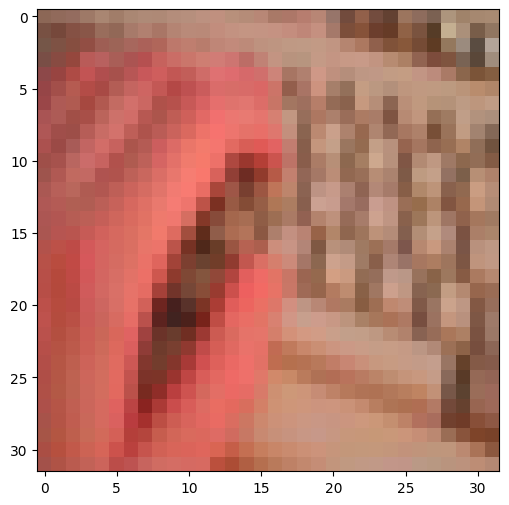

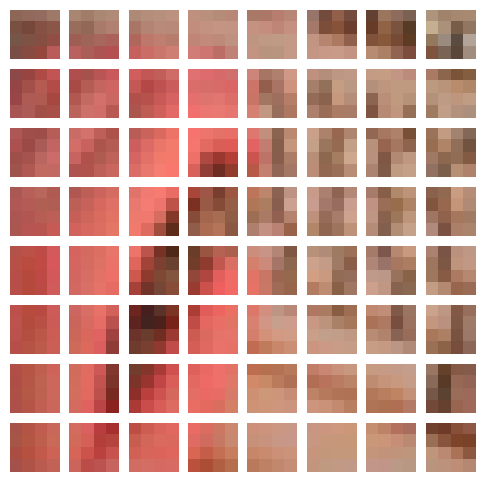

In [8]:
patch_test_X, patch_test_y = vit_dataloader._DataLoader__train_X[101], vit_dataloader._DataLoader__train_y[101]
patch_test_X = tf.expand_dims(patch_test_X, 0)
print('check shapes: ', patch_test_X.shape) 

patch_size=4 
generate_patch_layer = PatchGeneration(patch_size=patch_size)
patches = generate_patch_layer(patch_test_X)

print ('patch per image and patches shape: ', patches.shape[1], '\n', patches.shape)

def render_image_and_patches(image, patches):
    """
        this function used to show the actual image and patches of the image.
        Params:
            image(type: np.ndarray)  : Image, that needed to be patched.
            patches(type: tf.Tensor) : Patches, that are created from PatchGenerator.
        Return(None)
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(np.reshape(image, (32, 32, 3)))
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img)
        ax.axis('off')    

render_image_and_patches(patch_test_X, patches)

## **PatchEncoder**

In [9]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [10]:
patch_encoder = PatchEncoder(64, 64)
encoded_patches = patch_encoder(patches)
encoded_patches.shape

TensorShape([1, 64, 64])

## **Position Embedding Layer**

In [11]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(self, posemb_init=None, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)
        self.posemb_init = posemb_init
    
    def build(self, inputs_shape):
        pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
        self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

    def call(self, inputs, inputs_positions=None):
        pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)
        return inputs + pos_embedding

pos_embed_layer = PositionEmbedding(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))
embedded_inp = pos_embed_layer(encoded_patches)
print ('embedded input shape: ', embedded_inp.shape)
     

embedded input shape:  (1, 64, 64)


## **MLP Layer**

In [14]:
class MLPLayer(keras.layers.Layer):
    def __init__(self, hidden_dims1, hidden_dims2, rate):
        super(MLPLayer, self).__init__()
        self.hidden_dims1 = hidden_dims1
        self.hidden_dims2 = hidden_dims2
        self.dense1 = Dense(hidden_dims1, name="dense1")
        self.dropout = Dropout(rate)
        self.dense2 = Dense(hidden_dims2, name="dense2")
        self.act1 = ReLU(name="relu1")
        self.act2 = ReLU(name='relu2')
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.act2(x)
        return x

## **Transformer Single Encoder Layer**

In [15]:
 class EncoderLayer(keras.layers.Layer):
    def __init__(self, num_heads, mlp_dim1, mlp_di2):
        super(EncoderLayer, self).__init__()
        self.num_heads = num_heads 
        self.mlp_layer = MLPLayer(mlp_dim1, mlp_di2, 0.2)
        self.layer_norm = LayerNormalization()
        self.multihead_attention = MultiHeadAttention(self.num_heads,
                                        key_dim=64, dropout=0.1)
        self.add = Add()
        
    def call(self, inputs):
        x = self.layer_norm(inputs)
        attention_output = self.multihead_attention(x, x)
        x = Add()([attention_output, inputs])
        y = self.layer_norm(x)
        y = self.mlp_layer(y)
        y_1 = self.add([y, x])
        return y_1

## **Transformer Encoders Layer**

In [16]:
class EncoderFull(keras.layers.Layer):
    def __init__(self, n_encoders, mlp_dim1, mlp_dim2, num_heads, rate):
        super(EncoderFull, self).__init__()
        self.n_encoders = n_encoders
        self.mlp_dim1 = mlp_dim1
        self.mlp_dim2 = mlp_dim2
        self.num_heads = num_heads
        self.dropout = rate
        self.layer_norm = LayerNormalization()
        self.encoder_layer = EncoderLayer(self.num_heads, self.mlp_dim1, 
                                     self.mlp_dim2)
        self.position_emb_layer =  PositionEmbedding(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02),
                                                                                        name='posembed_input')

    def call(self, inputs):
        x = self.position_emb_layer(inputs)
        x = Dropout(rate=0.2)(x)
        for _ in range(self.n_encoders):
            x = self.encoder_layer(x)

        encoded = self.layer_norm(x)
        return encoded

## **VIT(Vision Transformer Model**

In [47]:
def build_ViT():
  
    inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))   # augmented input
   # augmented = data_augmentation(inputs)
    patches = PatchGeneration(patch_size=4)(inputs) # Patch Generation
    encoded_patches = PatchEncoder(NUM_PATCH, PATCH_DIMS)(patches)  # Encoding the patch.
    
    encoder_out = EncoderFull(NUM_ENCODER, MLP_DIMS_1, MLP_DIMS_2, NUM_HEAD, 0.2)(encoded_patches)  # Transformer Encoders
    im_representation = tf.reduce_mean(encoder_out, axis=1)   # image representation
 #   im_representation = keras.layers.Flatten()(encoder_out)
    dropout = Dropout(0.5)(im_representation)
    logits = Dense(units=NUM_CLS, name='head', activation='softmax')(im_representation) # output layer
    final_model = Model(inputs = inputs, outputs = logits)
    
    return final_model

In [48]:
model = build_ViT()

In [49]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 patch_generation_2 (PatchGe  (None, None, 48)         0         
 neration)                                                       
                                                                 
 patch_encoder_2 (PatchEncod  (None, 64, 64)           7232      
 er)                                                             
                                                                 
 encoder_full_2 (EncoderFull  (None, 64, 64)           236032    
 )                                                               
                                                                 
 tf.math.reduce_mean_1 (TFOp  (None, 64)               0         
 Lambda)                                                   

## **Adaptive Learning rate(Scheduled LR)**

In [50]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
               initial_learning_rate: float,
               decay_schedule_fn,
               warmup_steps: int,
               power: float = 1.0,
               name: str = None,):

        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
                "initial_learning_rate": self.initial_learning_rate,
                "decay_schedule_fn": self.decay_schedule_fn,
                "warmup_steps": self.warmup_steps,
                "power": self.power,
                "name": self.name,
                }

In [51]:
decay_steps = (len(train_ds))*1000
warmup_steps = (len(train_ds))*10
initial_lr = 5e-4

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate = initial_lr, 
                                                decay_steps = decay_steps)

cosine_with_warmUp = WarmUp(initial_learning_rate = initial_lr,
                          decay_schedule_fn = lr_decayed_fn,
                          warmup_steps = warmup_steps)

optimizer = keras.optimizers.Adam(cosine_with_warmUp)



In [52]:
learning_rate = 0.001
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

## **Model with tf.image.patch_generation method**

In [53]:

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True
                                        )
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=3
                                                          )
model.compile(optimizer=optimizer, 
              metrics=[
                    keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                    keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")], 
              loss=tf.keras.losses.SparseCategoricalCrossentropy())d

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100, 
                    callbacks=[model_checkpoint_callback, early_stopping_callback]
                   )


Epoch 1/100
196/196 [==============================] - 40s 174ms/step - loss: 4.3918 - accuracy: 0.0376 - top-5-accuracy: 0.1453 - val_loss: 4.0731 - val_accuracy: 0.0716 - val_top-5-accuracy: 0.2509
Epoch 2/100
196/196 [==============================] - 33s 169ms/step - loss: 3.9228 - accuracy: 0.0975 - top-5-accuracy: 0.2961 - val_loss: 3.7686 - val_accuracy: 0.1290 - val_top-5-accuracy: 0.3402
Epoch 3/100
196/196 [==============================] - 33s 169ms/step - loss: 3.6971 - accuracy: 0.1334 - top-5-accuracy: 0.3636 - val_loss: 3.6121 - val_accuracy: 0.1467 - val_top-5-accuracy: 0.3902
Epoch 4/100
196/196 [==============================] - 33s 168ms/step - loss: 3.5391 - accuracy: 0.1607 - top-5-accuracy: 0.4104 - val_loss: 3.4762 - val_accuracy: 0.1724 - val_top-5-accuracy: 0.4292
Epoch 5/100
196/196 [==============================] - 33s 169ms/step - loss: 3.4232 - accuracy: 0.1797 - top-5-accuracy: 0.4441 - val_loss: 3.3860 - val_accuracy: 0.1873 - val_top-5-accuracy: 0.4504


## **Plotting the Results**

In [54]:
import matplotlib.pyplot as plt 

def plot_acc(history, is_save=False, filename=None): 
    """
        this function, used to plot the Train data Accuracy and Val data Accuracy.
        Params:
            history(type: tf.History): history object, returned by the keras model .fit() method.
            if_save(dtype: Bool): whether need to show or save the plot.
            filename(type:str) : where the plt needed to be saved.
        Return(type: None)
    """
 #   assert is_save and filename, "Need a Filename, when is_save is True"
    with plt.xkcd():
        plt.plot(history.history["accuracy"], label="train_acc", )
        plt.plot(history.history["val_accuracy"], label="val_acc", )
        plt.title("Training and val Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
    
    if not is_save:
        plt.show()
    else:
        plt.savefig(filename)
        
        
def plot_loss(history, is_save=False, filename=None):  
    """
        this function, used to plot the Train data Loss and Val data Loss.
        Params:
            history(type: tf.History): history object, returned by the keras model .fit() method.
            if_save(dtype: Bool): whether need to show or save the plot.
            filename(type:str) : where the plt needed to be saved.
        Return(type: None)
    """
#    assert is_save and filename, "Need a Filename, when is_save is True"
    with plt.xkcd():
        plt.plot(history.history["loss"], label="train_loss",  color="pink")
        plt.plot(history.history["val_loss"], label="val_loss", color="green")

        plt.title("Training Loss and val loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        
    if not is_save:
        plt.show()
    else:
        plt.savefig(filename)
        

def plot_acc_top_5(history, is_save=False, filename=None): 
    """
        this function, used to plot the Train data Accuracy and Val data Accuracy.
        Params:
            history(type: tf.History): history object, returned by the keras model .fit() method.
            if_save(dtype: Bool): whether need to show or save the plot.
            filename(type:str) : where the plt needed to be saved.
        Return(type: None)
    """
  #  assert is_save and filename, "Need a Filename, when is_save is True"
    with plt.xkcd():
        plt.plot(history.history["top-5-accuracy"], label="train_acc", color="pink")
        plt.plot(history.history["val_top-5-accuracy"], label="val_acc", color="green")
        plt.title("Training and val Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
        
    if not is_save:
        plt.show()
    else:
        plt.savefig(filename)

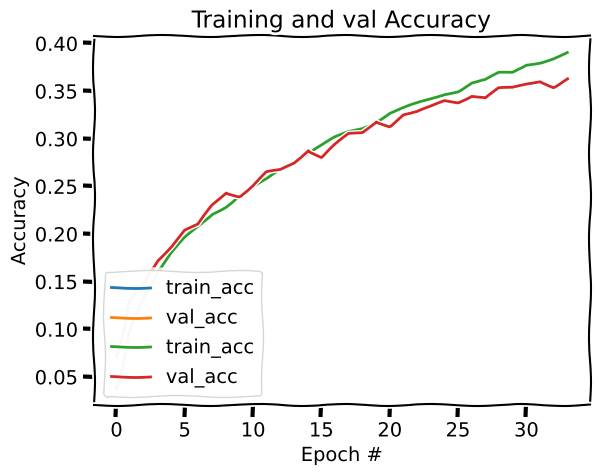

In [55]:
plot_acc(history, True, "vit_custom_pg_acc1.png")
plot_acc(history)

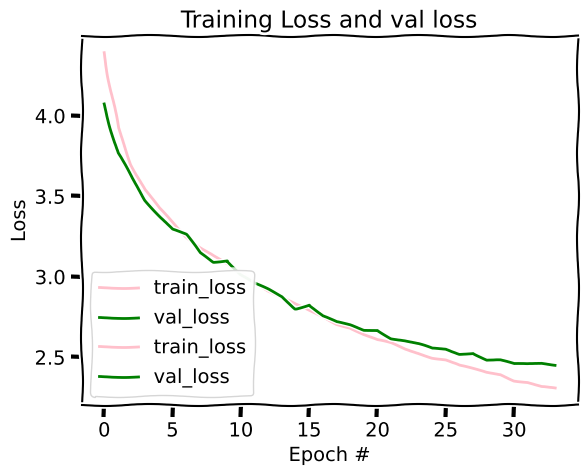

In [56]:
plot_loss(history, True, "vit_custom_pg_loss1.png")
plot_loss(history)


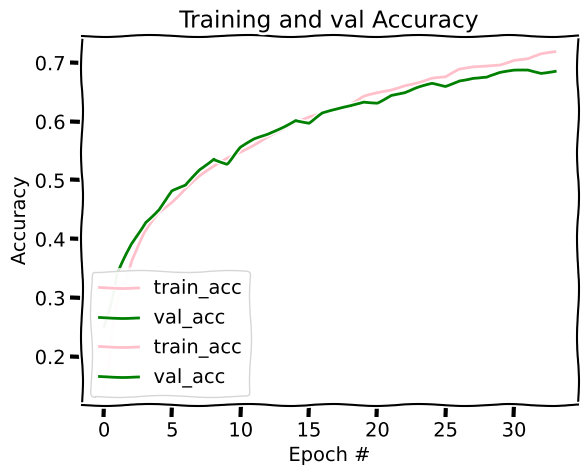

In [57]:
plot_acc_top_5(history, True, "vit_custom_pg_top5acc1.png")
plot_acc_top_5(history)

In [58]:
model.save("vit_model_w_custom_pg1.h5")

## **Model with Paper based Patch Method**

In [64]:
def build_ViT():
  
    inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))   # augmented input
    
    patches = generate_patch_conv_orgPaper_f(PATCH_SIZE, PATCH_DIMS, inputs) # Patch Generation
    encoded_patches = PatchEncoder(NUM_PATCH, PATCH_DIMS)(patches)  # Encoding the patch.
    
    encoder_out = EncoderFull(NUM_ENCODER, MLP_DIMS_1, MLP_DIMS_2, NUM_HEAD, 0.2)(encoded_patches)  # Transformer Encoders
    im_representation = tf.reduce_mean(encoder_out, axis=1)   # image representation
 #   im_representation = keras.layers.Flatten()(encoder_out)
    dropout = Dropout(0.5)(im_representation)
    logits = Dense(units=NUM_CLS, name='head', activation='softmax')(im_representation) # output layer
    final_model = Model(inputs = inputs, outputs = logits)
    
    return final_model

In [65]:
model = build_ViT()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          3136      
                                                                 
 tf.reshape (TFOpLambda)     (None, 64, 64)            0         
                                                                 
 patch_encoder_3 (PatchEncod  (None, 64, 64)           8256      
 er)                                                             
                                                                 
 encoder_full_3 (EncoderFull  (None, 64, 64)           236032    
 )                                                               
                                                                 
 tf.math.reduce_mean_2 (TFOp  (None, 64)               0   

## **Adaptive Learning rate(scheduled lr)**

In [ ]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
               initial_learning_rate: float,
               decay_schedule_fn,
               warmup_steps: int,
               power: float = 1.0,
               name: str = None,):

        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
                "initial_learning_rate": self.initial_learning_rate,
                "decay_schedule_fn": self.decay_schedule_fn,
                "warmup_steps": self.warmup_steps,
                "power": self.power,
                "name": self.name,
                }

In [ ]:
decay_steps = (len(train_ds))*1000
warmup_steps = (len(train_ds))*10
initial_lr = 5e-4

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate = initial_lr, 
                                                decay_steps = decay_steps)

cosine_with_warmUp = WarmUp(initial_learning_rate = initial_lr,
                          decay_schedule_fn = lr_decayed_fn,
                          warmup_steps = warmup_steps)

optimizer = keras.optimizers.Adam(cosine_with_warmUp)

In [66]:
learning_rate = 0.001
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

In [68]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True
                                        )
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=3
                                                          )
model.compile(optimizer=optimizer, 
              metrics=[
                    keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                    keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")], 
              loss=tf.keras.losses.SparseCategoricalCrossentropy())

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100, 
                    callbacks=[model_checkpoint_callback, early_stopping_callback]
                   )


Epoch 1/100
196/196 [==============================] - 41s 176ms/step - loss: 4.3570 - accuracy: 0.0397 - top-5-accuracy: 0.1542 - val_loss: 4.0655 - val_accuracy: 0.0767 - val_top-5-accuracy: 0.2538
Epoch 2/100
196/196 [==============================] - 33s 169ms/step - loss: 3.9063 - accuracy: 0.0983 - top-5-accuracy: 0.2986 - val_loss: 3.8053 - val_accuracy: 0.1145 - val_top-5-accuracy: 0.3271
Epoch 3/100
196/196 [==============================] - 33s 169ms/step - loss: 3.7143 - accuracy: 0.1288 - top-5-accuracy: 0.3554 - val_loss: 3.6532 - val_accuracy: 0.1410 - val_top-5-accuracy: 0.3738
Epoch 4/100
196/196 [==============================] - 33s 169ms/step - loss: 3.5743 - accuracy: 0.1523 - top-5-accuracy: 0.3999 - val_loss: 3.5562 - val_accuracy: 0.1589 - val_top-5-accuracy: 0.4074
Epoch 5/100
196/196 [==============================] - 33s 169ms/step - loss: 3.4554 - accuracy: 0.1739 - top-5-accuracy: 0.4317 - val_loss: 3.4266 - val_accuracy: 0.1829 - val_top-5-accuracy: 0.4466


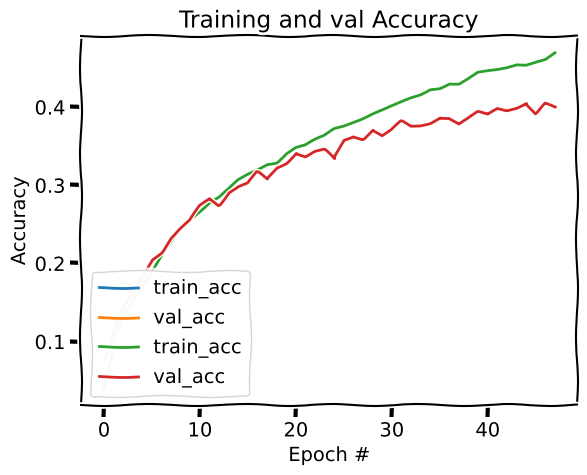

In [69]:
plot_acc(history, True, "vit_paper_pg_acc.png")
plot_acc(history)

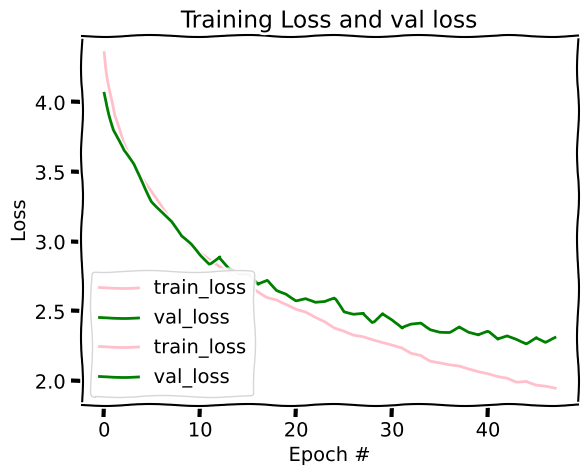

In [70]:
plot_loss(history, True, "vit_paper_pg_loss.png")
plot_loss(history)

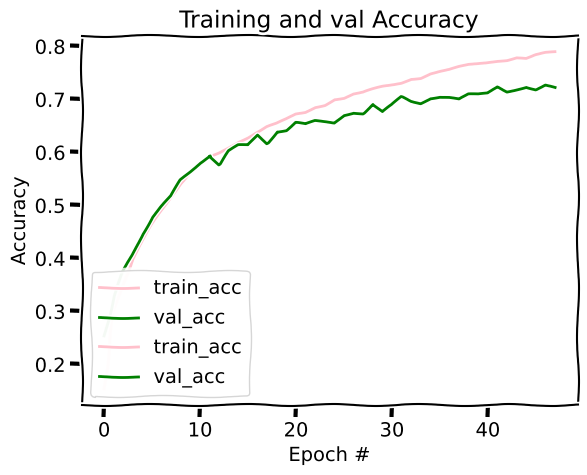

In [71]:
plot_acc_top_5(history, True, "vit_paper_pg_top5acc.png")
plot_acc_top_5(history)

In [72]:
model.save("vit_model_original_pg1.h5")

## **Manual Training of the VIT Model**

In [ ]:
class VModel(keras.Model): 
    def __init__(self, output_dims):
        super(VModel, self).__init__()
        self.patch_gen = PatchGeneration(patch_size=4)
        self.patch_encoder = PatchEncoder(64, 64)
        self.encoders = EncoderFull(6, 128, 64, 6, 0.2)
        self.out = Dense(units=output_dims, name='head', activation="softmax")
    
    def call(self, inputs):
        patches = self.patch_gen((inputs))
        encoded_patches = self.patch_encoder(patches)
        encoder_out = self.encoders((encoded_patches))
        im_representation = tf.reduce_mean(encoder_out, axis=1)
        normalized_logits = self.out((im_representation))
        return normalized_logits

In [ ]:
m = VModel()

In [ ]:
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
        """
            this method does the manual tr
            ain step using the gradient tape.
            Params: 
                x(type: tf.data.Dataset): Independent Variable of type tf.data.Dataset.
                y(type: tf.data.Dataset): dependent Variable of type tf.data.Dataset.
                model(type; tf.models.Model): keras model, that will be used for the prediction.
                optimizer(tf.optimizer): Optimizer for updating the gradients.
                loss_fn(type: tf.losses): Loss function for calculating the loss of the model.
                train_acc_metric(type; tf.accuracy): Metric function for evaluation the data.
            
            Return(type: float)
                this method returns the loss value of the training data.
        """
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            print(logits[0], l)
            loss_value = loss_fn(y, logits)
            print(loss_value)
        
        model_params = model.trainable_weights
        grads = tape.gradient(loss_value, model_params)
        optimizer.apply_gradients(zip(grads, model_params))

        return loss_value

In [ ]:
import tqdm 
def manual_train(train_dataset,
            val_dataset, 
            model,
            optimizer,
            loss_fn,
            train_acc_metric,
            val_acc_metric,
            epochs=10, 
            log_step=200, 
            val_log_step=50):

        """
            this method, does the manual train and test step for multiple epochs
            Params: 
                epochs(type; int): Number of epoch model needed to be trained.
                log_step(type:int): Number of train step.
                val_log_step(type:int): Number of val step.
                x(type: tf.data.Dataset): Independent Variable of type tf.data.Dataset.
                y(type: tf.data.Dataset): dependent Variable of type tf.data.Dataset.
                model(type; tf.models.Model): keras model, that will be used for the prediction.
                loss_fn(type: tf.losses): Loss function for calculating the loss of the model.
                val_acc_metric(type; tf.accuracy): Metric function for evaluation the data.

        """
    
        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))

            train_loss = []   
            val_loss = []

            # Iterate over the batches of the dataset
            for step, (x_batch_train, y_batch_train) in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
                loss_value = train_step(x_batch_train, y_batch_train, 
                                        model, optimizer, 
                                        loss_fn, train_acc_metric)
                train_loss.append(float(loss_value))

            # Run a validation loop at the end of each epoch
            
            print("Training acc over epoch: %.4f" % (np.mean(train_loss),))
